<a href="https://colab.research.google.com/github/Englishson0909/S24Corpus-final/blob/main/finalcodesRQS0619.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
RQ1

In [1]:
pip install pandas requests

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Contingency Table:
      Frequency of very  Other words
TED                 465       219090
COCA                201       219306

Chi-Square Test Results
Chi-square statistic: 103.95755224865117
P-value: 2.0669728733378416e-24
Degrees of freedom: 1

Expected frequencies:
      Frequency of very    Other words
TED          333.036405  219221.963595
COCA         332.963595  219174.036405
Results saved to CSV files successfully.


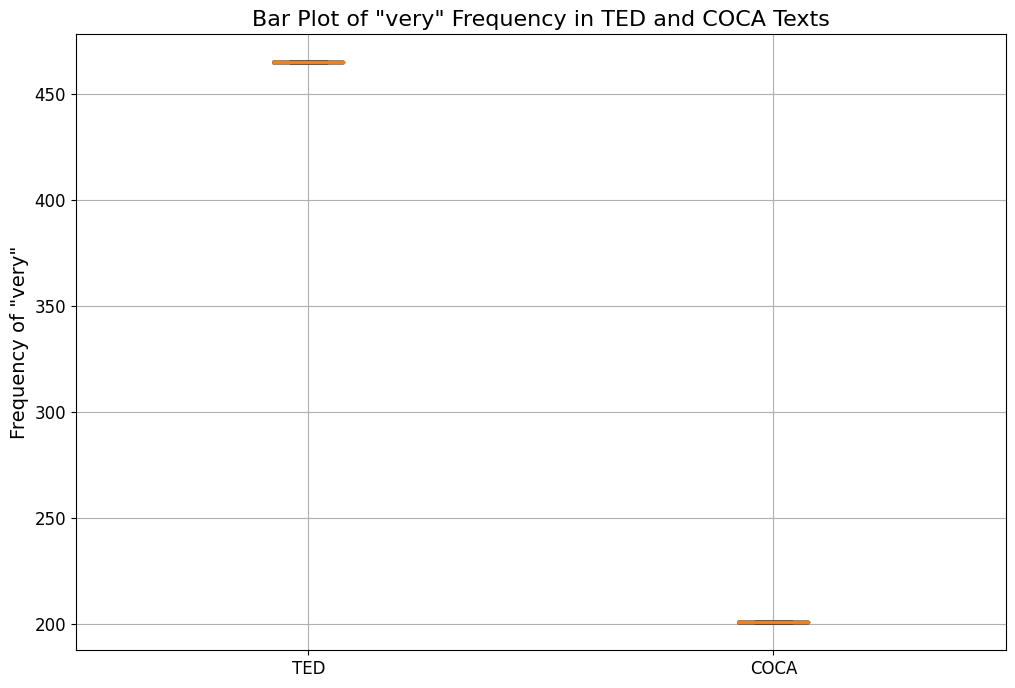

In [2]:
import requests
import pandas as pd
from io import StringIO
import re
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag, word_tokenize

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def download_csv(url):
    """Download a CSV file from a given URL and return it as a pandas DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        csv_raw = StringIO(response.text)
        df = pd.read_csv(csv_raw)
        # Convert all text to lowercase
        df = df.applymap(lambda s: s.lower() if type(s) == str else s)
        return df
    else:
        raise Exception(f"Failed to download CSV. Status code: {response.status_code}")

def count_specific_word(df, word):
    """Count occurrences of a specific word in a DataFrame, considering all text columns."""
    text = ' '.join(df.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1))
    words_list = re.findall(r'\b{}\b'.format(re.escape(word.lower())), text.lower())  # Find all instances of the word
    return len(words_list)

# URLs of the CSV files (use the raw version of the files from GitHub)
ted_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/TEDcleandata.csv'
coca_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/finalcocatext.csv'

try:
    # Download the CSV files from GitHub and convert text to lowercase
    df_ted = download_csv(ted_csv_url)
    df_coca = download_csv(coca_csv_url)

    # Count occurrences of the word "very" in each text
    word_to_count = "very"
    count_ted = count_specific_word(df_ted, word_to_count)
    count_coca = count_specific_word(df_coca, word_to_count)

    # Total word count for each text
    total_words_ted = len(' '.join(df_ted.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1)).split())
    total_words_coca = len(' '.join(df_coca.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1)).split())

    # Create a 2x2 contingency table
    contingency_table = [
        [count_ted, total_words_ted - count_ted],
        [count_coca, total_words_coca - count_coca]
    ]

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Create DataFrames for better display
    contingency_table_df = pd.DataFrame(contingency_table, columns=['Frequency of very', 'Other words'], index=['TED', 'COCA'])
    expected_df = pd.DataFrame(expected, columns=['Frequency of very', 'Other words'], index=['TED', 'COCA'])

    # Display results
    print("\nContingency Table:")
    print(contingency_table_df)
    print("\nChi-Square Test Results")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected frequencies:")
    print(expected_df)

    # Save results to CSV files
    contingency_table_df.to_csv('contingency_table01.csv', index=True)
    expected_df.to_csv('expected_frequencies01.csv', index=True)

    # Save the chi-square test results to a CSV file
    results_df = pd.DataFrame({
        'Chi-square statistic': [chi2],
        'P-value': [p],
        'Degrees of freedom': [dof]
    })
    results_df.to_csv('chi_square_results01.csv', index=False)

    print("Results saved to CSV files successfully.")

    # Create a box plot for the frequency of "very"
    data = {'TED': [count_ted], 'COCA': [count_coca]}
    df_box = pd.DataFrame(data)

    plt.figure(figsize=(12, 8))  # Increase the size of the plot
    boxprops = dict(linewidth=2.5)  # Thicken the box lines
    medianprops = dict(linewidth=2.5)  # Thicken the median line
    whiskerprops = dict(linewidth=2.5)  # Thicken the whisker lines
    capprops = dict(linewidth=2.5)  # Thicken the cap lines

    df_box.boxplot(column=['TED', 'COCA'], boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
    plt.title('Bar Plot of "very" Frequency in TED and COCA Texts', fontsize=16)
    plt.ylabel('Frequency of "very"', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

except Exception as e:
    print(e)


RQ 2 What are the distributional patterns of "very" as an adverb, adjective, and noun in written and spoken text?

In [ ]:
import requests
import pandas as pd
from io import StringIO
import re
import spacy
from collections import Counter
from scipy.stats import chi2_contingency

# Load SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Increase the maximum length limit for SpaCy
nlp.max_length = 2000000  # Adjusted to handle larger texts

def download_csv(url):
    """Download a CSV file from a given URL and return it as a pandas DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        csv_raw = StringIO(response.text)
        df = pd.read_csv(csv_raw)
        return df
    else:
        raise Exception(f"Failed to download CSV. Status code: {response.status_code}")

def extract_text(df):
    """Extract and combine text from all columns of a DataFrame."""
    text = ' '.join(df.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1))
    text = re.sub(r'\s+', ' ', text.strip())  # Clean up any extra spaces
    return text

def classify_very_in_chunks(text, chunk_size=100000):
    """Classify occurrences of 'very' in a text by processing in chunks."""
    classified = Counter({'adverb': 0, 'adjective': 0})
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        doc = nlp(chunk)
        for token in doc:
            if token.text.lower() == 'very':
                if token.pos_ == 'ADV':
                    classified['adverb'] += 1
                elif token.pos_ == 'ADJ':
                    classified['adjective'] += 1
    return classified

# URLs of the CSV files (use the raw version of the files from GitHub)
ted_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/TEDcleandata.csv'
coca_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/finalcocatext.csv'

try:
    # Download the CSV files from GitHub
    df_ted = download_csv(ted_csv_url)
    df_coca = download_csv(coca_csv_url)

    # Extract text from the DataFrames
    text_ted = extract_text(df_ted)
    text_coca = extract_text(df_coca)

    # Classify occurrences of 'very' in each text
    classified_ted = classify_very_in_chunks(text_ted)
    classified_coca = classify_very_in_chunks(text_coca)

    # Create a contingency table
    contingency_table = [
        [classified_ted['adverb'], classified_coca['adverb']],
        [classified_ted['adjective'], classified_coca['adjective']]
    ]

    # Add a small constant to avoid zero counts
    contingency_table = [[cell + 0.5 for cell in row] for row in contingency_table]

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Create DataFrames for better display
    contingency_table_df = pd.DataFrame(contingency_table, columns=['TED', 'COCA'], index=['Adverb', 'Adjective'])
    expected_df = pd.DataFrame(expected, columns=['TED', 'COCA'], index=['Adverb', 'Adjective'])

    # Display results
    print("\nContingency Table:")
    print(contingency_table_df)
    print("\nChi-Square Test Results")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected frequencies:")
    print(expected_df)

    # Save results to CSV files
    contingency_table_df.to_csv('contingency_table2.csv', index=True)
    expected_df.to_csv('expected_frequencies2.csv', index=True)

    # Save the chi-square test results to a CSV file
    results_df = pd.DataFrame({
        'Chi-square statistic': [chi2],
        'P-value': [p],
        'Degrees of freedom': [dof]
    })
    results_df.to_csv('chi_square_results2.csv', index=False)

    print("Results saved to CSV files successfully.")

except Exception as e:
    print(e)



Contingency Table:
             TED   COCA
Adverb     449.5  193.5
Adjective   15.5    8.5

Chi-Square Test Results
Chi-square statistic: 0.10958192894491381
P-value: 0.7406206065855065
Degrees of freedom: 1

Expected frequencies:
                  TED        COCA
Adverb     448.268366  194.731634
Adjective   16.731634    7.268366
Results saved to CSV files successfully.


In [ ]:
import requests
import pandas as pd
from io import StringIO
import re
import spacy
from collections import Counter
from scipy.stats import chi2_contingency

# Load SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Increase the maximum length limit for SpaCy
nlp.max_length = 2000000  # Adjusted to handle larger texts

def download_csv(url):
    """Download a CSV file from a given URL and return it as a pandas DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        csv_raw = StringIO(response.text)
        df = pd.read_csv(csv_raw)
        return df
    else:
        raise Exception(f"Failed to download CSV. Status code: {response.status_code}")

def extract_text(df):
    """Extract and combine text from all columns of a DataFrame."""
    text = ' '.join(df.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1))
    text = re.sub(r'\s+', ' ', text.strip())  # Clean up any extra spaces
    return text

def classify_very_in_chunks(text, chunk_size=100000):
    """Classify occurrences of 'very' in a text by processing in chunks."""
    classified = Counter({'adverb': 0, 'adjective': 0})
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        doc = nlp(chunk)
        for token in doc:
            if token.text.lower() == 'very':
                if token.pos_ == 'ADV':
                    classified['adverb'] += 1
                elif token.pos_ == 'ADJ':
                    classified['adjective'] += 1
    return classified

# URLs of the CSV files (use the raw version of the files from GitHub)
ted_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/TEDcleandata.csv'
coca_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/finalcocatext.csv'

try:
    # Download the CSV files from GitHub
    df_ted = download_csv(ted_csv_url)
    df_coca = download_csv(coca_csv_url)

    # Extract text from the DataFrames
    text_ted = extract_text(df_ted)
    text_coca = extract_text(df_coca)

    # Classify occurrences of 'very' in each text
    classified_ted = classify_very_in_chunks(text_ted)
    classified_coca = classify_very_in_chunks(text_coca)

    # Create a contingency table
    contingency_table = [
        [classified_ted['adverb'], classified_coca['adverb']],
        [classified_ted['adjective'], classified_coca['adjective']]
    ]

    # Check if any value is zero
    if any(value == 0 for row in contingency_table for value in row):
        print("Contingency table contains zero values, which may invalidate the chi-square test.")
    else:
        # Perform chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Create DataFrames for better display
        contingency_table_df = pd.DataFrame(contingency_table, columns=['TED', 'COCA'], index=['Adverb', 'Adjective'])
        expected_df = pd.DataFrame(expected, columns=['TED', 'COCA'], index=['Adverb', 'Adjective'])

        # Display results
        print("\nContingency Table:")
        print(contingency_table_df)
        print("\nChi-Square Test Results")
        print(f"Chi-square statistic: {chi2}")
        print(f"P-value: {p}")
        print(f"Degrees of freedom: {dof}")
        print("\nExpected frequencies:")
        print(expected_df)

        # Save results to CSV files
        contingency_table_df.to_csv('contingency_table2.csv', index=True)
        expected_df.to_csv('expected_frequencies2.csv', index=True)

        # Save the chi-square test results to a CSV file
        results_df = pd.DataFrame({
            'Chi-square statistic': [chi2],
            'P-value': [p],
            'Degrees of freedom': [dof]
        })
        results_df.to_csv('chi_square_results2.csv', index=False)

        print("Results saved to CSV files successfully.")

except Exception as e:
    print(e)



Contingency Table:
           TED  COCA
Adverb     449   193
Adjective   15     8

Chi-Square Test Results
Chi-square statistic: 0.0641563737197867
P-value: 0.8000432847156983
Degrees of freedom: 1

Expected frequencies:
                 TED       COCA
Adverb     447.95188  194.04812
Adjective   16.04812    6.95188
Results saved to CSV files successfully.


Q3

In [ ]:
import requests
import pandas as pd
from io import StringIO
import re
import spacy
from collections import Counter
from scipy.stats import chi2_contingency

# Load SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Increase the maximum length limit for SpaCy
nlp.max_length = 2000000  # Adjusted to handle larger texts

def download_csv(url):
    """Download a CSV file from a given URL and return it as a pandas DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        csv_raw = StringIO(response.text)
        df = pd.read_csv(csv_raw)
        return df
    else:
        raise Exception(f"Failed to download CSV. Status code: {response.status_code}")

def extract_text(df):
    """Extract and combine text from all columns of a DataFrame."""
    text = ' '.join(df.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1))
    text = re.sub(r'\s+', ' ', text.strip())  # Clean up any extra spaces
    return text

def classify_very_in_chunks(text, chunk_size=100000):
    """Classify occurrences of 'very' in a text by processing in chunks."""
    classified = Counter({'adverb': 0, 'adjective': 0, 'noun': 0})
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        doc = nlp(chunk)
        for token in doc:
            if token.text.lower() == 'very':
                if token.pos_ == 'ADV':
                    classified['adverb'] += 1
                elif token.pos_ == 'ADJ':
                    classified['adjective'] += 1
                elif token.pos_ == 'NOUN':
                    classified['noun'] += 1
    return classified

# URLs of the CSV files (use the raw version of the files from GitHub)
ted_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/TEDcleandata.csv'
coca_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/finalcocatext.csv'

try:
    # Download the CSV files from GitHub
    df_ted = download_csv(ted_csv_url)
    df_coca = download_csv(coca_csv_url)

    # Extract text from the DataFrames
    text_ted = extract_text(df_ted)
    text_coca = extract_text(df_coca)

    # Classify occurrences of 'very' in each text
    classified_ted = classify_very_in_chunks(text_ted)
    classified_coca = classify_very_in_chunks(text_coca)

    # Create a contingency table
    contingency_table = [
        [classified_ted['adverb'], classified_coca['adverb']],
        [classified_ted['adjective'], classified_coca['adjective']],
        [classified_ted['noun'], classified_coca['noun']]
    ]

    # Add a small constant to avoid zero counts
    contingency_table = [[cell + 0.5 for cell in row] for row in contingency_table]

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Create DataFrames for better display
    contingency_table_df = pd.DataFrame(contingency_table, columns=['TED', 'COCA'], index=['Adverb', 'Adjective', 'Noun'])
    expected_df = pd.DataFrame(expected, columns=['TED', 'COCA'], index=['Adverb', 'Adjective', 'Noun'])

    # Display results
    print("\nContingency Table:")
    print(contingency_table_df)
    print("\nChi-Square Test Results")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected frequencies:")
    print(expected_df)

    # Save results to CSV files
    contingency_table_df.to_csv('contingency_table2.csv', index=True)
    expected_df.to_csv('expected_frequencies2.csv', index=True)

    # Save the chi-square test results to a CSV file
    results_df = pd.DataFrame({
        'Chi-square statistic': [chi2],
        'P-value': [p],
        'Degrees of freedom': [dof]
    })
    results_df.to_csv('chi_square_results2.csv', index=False)

    print("Results saved to CSV files successfully.")

except Exception as e:
    print(e)



Contingency Table:
             TED   COCA
Adverb     449.5  193.5
Adjective   15.5    8.5
Noun         0.5    0.5

Chi-Square Test Results
Chi-square statistic: 0.49408724550960664
P-value: 0.7811066187656586
Degrees of freedom: 2

Expected frequencies:
                  TED        COCA
Adverb     448.078593  194.921407
Adjective   16.724551    7.275449
Noun         0.696856    0.303144
Results saved to CSV files successfully.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Most common collocations with 'very' in the first dataset: [(('very', 'much'), 33), (('very', 'very'), 25), (('very', 'good'), 19), (('very', 'different'), 17), (('very', 'important'), 14), (('very', 'quickly'), 12), (('very', 'well'), 11), (('very', 'simple'), 8), (('very', 'hard'), 7), (('very', 'first'), 6), (('very', 'difficult'), 6), (('very', 'high'), 6), (('very', 'little'), 5), (('very', 'clear'), 5), (('very', 'low'), 5), (('very', 'similar'), 5), (('very', 'small'), 5), (('very', 'bad'), 5), (('very', 'large'), 5), (('very', 'early'), 4)]
Most common collocations with 'very' in the second dataset: [(('very', 'much'), 10), (('very', 'well'), 9), (('very', 'good'), 6), (('very', 'little'), 6), (('very', 'close'), 5), (('very', 'hard'), 5), (('very', 'few'), 4), (('very', 'different'), 4), (('very', 'odd'), 4), (('very', 'serious'), 3), (('very', 'short'), 3), (('very', 'strong'), 3), (('very', 'important'), 3), (('very', 'difficult'), 3), (('very', 'quickly'), 3)]

Collocations

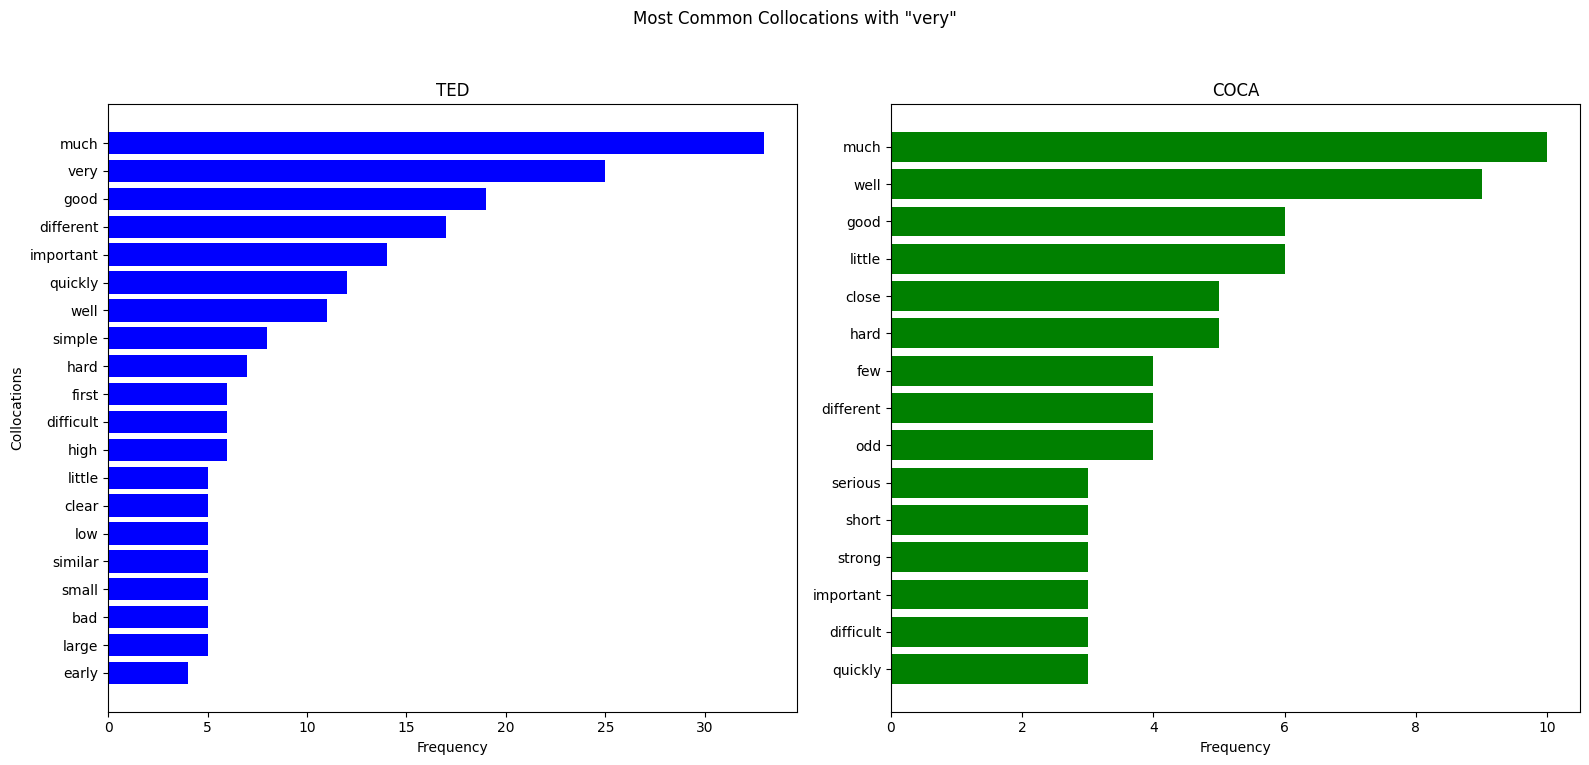

In [ ]:
import requests
import pandas as pd
import nltk
from io import StringIO
import matplotlib.pyplot as plt
from collections import Counter
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from scipy.stats import chi2_contingency

# Download NLTK data files (only need to be done once)
nltk.download('punkt')

def download_csv(url):
    """Download a CSV file from a given URL and return it as a pandas DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        csv_raw = StringIO(response.text)
        df = pd.read_csv(csv_raw)
        return df
    else:
        raise Exception(f"Failed to download CSV. Status code: {response.status_code}")

def extract_text(df):
    """Extract and combine text from all columns of a DataFrame."""
    text = ' '.join(df.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1))
    return text

def find_collocations(text, word, top_n=20):
    """Find and return the most common collocations with a given word."""
    tokens = nltk.word_tokenize(text.lower())
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(3)  # Filter out bigrams that appear less than 3 times
    collocations = finder.ngram_fd.items()
    # Only consider bigrams where 'very' is the first word
    filtered_collocations = [(ngram, freq) for ngram, freq in collocations if ngram[0] == word]
    sorted_collocations = sorted(filtered_collocations, key=lambda x: x[1], reverse=True)
    return sorted_collocations[:top_n]

def plot_collocations(collocations1, collocations2, word, title1, title2):
    """Plot the most common collocations with a given word for two datasets."""
    collocation_words1 = [ngram[1] for ngram, _ in collocations1]
    frequencies1 = [freq for _, freq in collocations1]

    collocation_words2 = [ngram[1] for ngram, _ in collocations2]
    frequencies2 = [freq for _, freq in collocations2]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    axes[0].barh(collocation_words1, frequencies1, color='blue')
    axes[0].set_xlabel('Frequency')
    axes[0].set_ylabel('Collocations')
    axes[0].set_title(title1)
    axes[0].invert_yaxis()

    axes[1].barh(collocation_words2, frequencies2, color='green')
    axes[1].set_xlabel('Frequency')
    axes[1].set_title(title2)
    axes[1].invert_yaxis()

    plt.suptitle(f'Most Common Collocations with "{word}"')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('collocations_barplot03.png')
    plt.show()

# URLs of the CSV files (use the raw version of the file from GitHub)
csv_url1 = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/TEDcleandata.csv'
csv_url2 = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/finalcocatext.csv'

try:
    # Download the CSV files from GitHub
    df1 = download_csv(csv_url1)
    df2 = download_csv(csv_url2)

    # Extract text from the DataFrames
    text1 = extract_text(df1)
    text2 = extract_text(df2)

    # Find the most common collocations with the word "very" in both datasets
    collocations1 = find_collocations(text1, 'very')
    collocations2 = find_collocations(text2, 'very')

    # Output the results
    print(f"Most common collocations with 'very' in the first dataset: {collocations1}")
    print(f"Most common collocations with 'very' in the second dataset: {collocations2}")

    # Convert collocations to DataFrame for chi-square test
    words = list(set([ngram[1] for ngram, _ in collocations1 + collocations2]))
    collocations_df = pd.DataFrame(index=words, columns=['TED', 'COCA']).fillna(0).astype(int)

    for ngram, freq in collocations1:
        collocations_df.at[ngram[1], 'TED'] = freq

    for ngram, freq in collocations2:
        collocations_df.at[ngram[1], 'COCA'] = freq

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(collocations_df)

    # Create DataFrames for better display
    expected_df = pd.DataFrame(expected, index=collocations_df.index, columns=['TED', 'COCA']).astype(int)

    # Add totals to the contingency table
    collocations_df.loc['Total'] = collocations_df.sum()
    expected_df.loc['Total'] = expected_df.sum()
    collocations_df['Total'] = collocations_df.sum(axis=1)
    expected_df['Total'] = expected_df.sum(axis=1)

    # Display results
    print("\nCollocations DataFrame:")
    print(collocations_df)
    print("\nChi-Square Test Results")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected frequencies:")
    print(expected_df)

    # Save results to CSV files
    collocations_df.to_csv('collocations03.csv', index=True)
    expected_df.to_csv('expected_frequencies03.csv', index=True)
    results_df = pd.DataFrame({
        'Chi-square statistic': [chi2],
        'P-value': [p],
        'Degrees of freedom': [dof]
    })
    results_df.to_csv('chi_square_results03.csv', index=False)

    print("Results saved to CSV files successfully.")

    # Plot the collocations
    plot_collocations(collocations1, collocations2, 'very', 'TED', 'COCA')

except Exception as e:
    print(e)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Most common collocations with 'very' in the first dataset: [(('very', 'much'), 33), (('very', 'very'), 25), (('very', 'good'), 19), (('very', 'different'), 17), (('very', 'important'), 14), (('very', 'quickly'), 12), (('very', 'well'), 11), (('very', 'simple'), 8), (('very', 'hard'), 7), (('very', 'first'), 6), (('very', 'difficult'), 6), (('very', 'high'), 6), (('very', 'little'), 5), (('very', 'clear'), 5), (('very', 'low'), 5), (('very', 'similar'), 5), (('very', 'small'), 5), (('very', 'bad'), 5), (('very', 'large'), 5), (('very', 'early'), 4)]
Most common collocations with 'very' in the second dataset: [(('very', 'much'), 10), (('very', 'well'), 9), (('very', 'good'), 6), (('very', 'little'), 6), (('very', 'close'), 5), (('very', 'hard'), 5), (('very', 'few'), 4), (('very', 'different'), 4), (('very', 'odd'), 4), (('very', 'serious'), 3), (('very', 'short'), 3), (('very', 'strong'), 3), (('very', 'important'), 3), (('very', 'difficult'), 3), (('very', 'quickly'), 3)]

Collocations

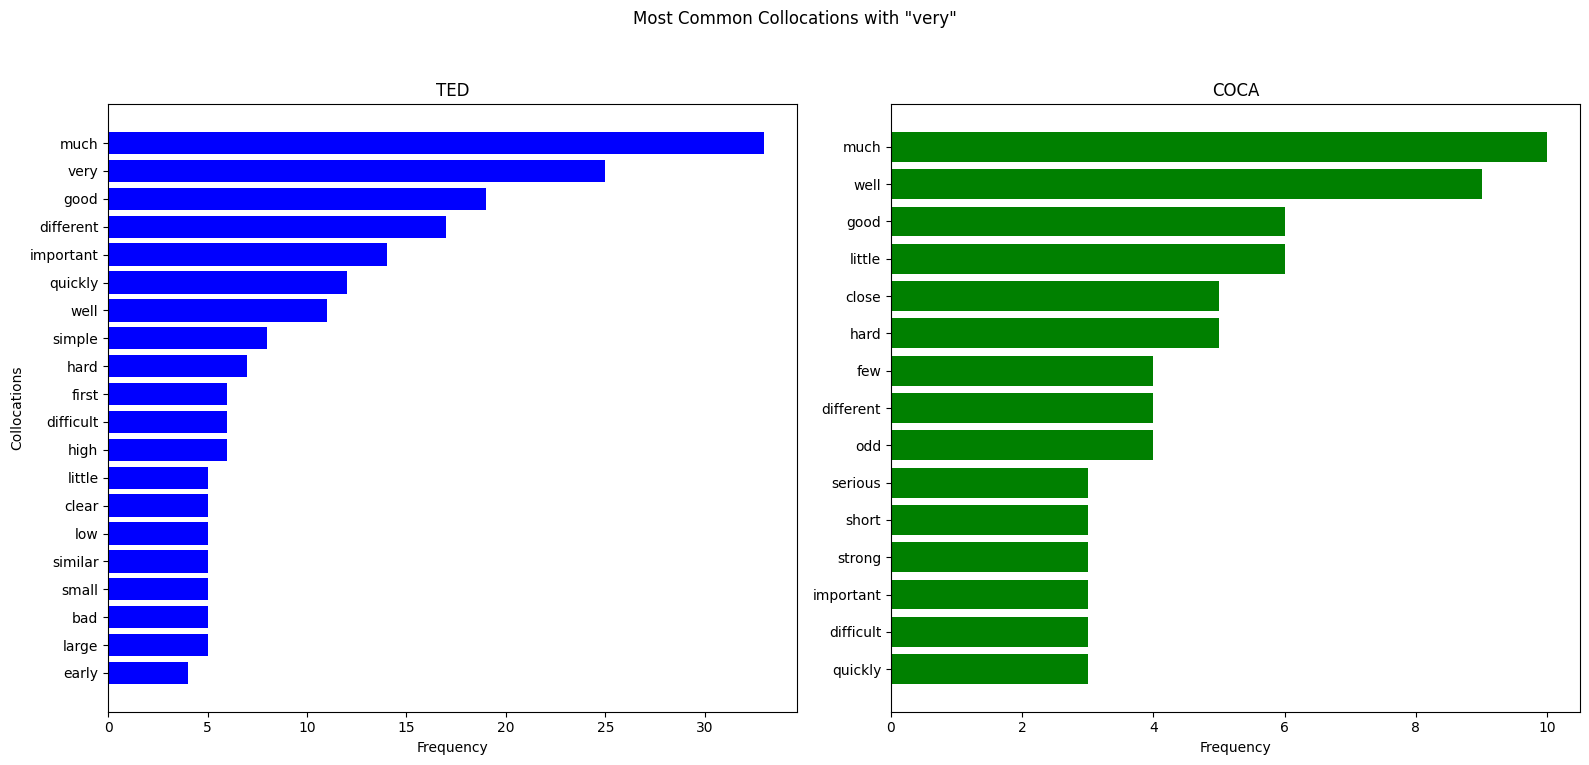

In [ ]:
import requests
import pandas as pd
import nltk
from io import StringIO
import matplotlib.pyplot as plt
from collections import Counter
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from scipy.stats import chi2_contingency

# Download NLTK data files (only need to be done once)
nltk.download('punkt')

def download_csv(url):
    """Download a CSV file from a given URL and return it as a pandas DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        csv_raw = StringIO(response.text)
        df = pd.read_csv(csv_raw)
        return df
    else:
        raise Exception(f"Failed to download CSV. Status code: {response.status_code}")

def extract_text(df):
    """Extract and combine text from all columns of a DataFrame."""
    text = ' '.join(df.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1))
    return text

def find_collocations(text, word, top_n=20):
    """Find and return the most common collocations with a given word."""
    tokens = nltk.word_tokenize(text.lower())
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(3)  # Filter out bigrams that appear less than 3 times
    collocations = finder.ngram_fd.items()
    # Only consider bigrams where 'very' is the first word
    filtered_collocations = [(ngram, freq) for ngram, freq in collocations if ngram[0] == word]
    sorted_collocations = sorted(filtered_collocations, key=lambda x: x[1], reverse=True)
    return sorted_collocations[:top_n]

def plot_collocations(collocations1, collocations2, word, title1, title2):
    """Plot the most common collocations with a given word for two datasets."""
    collocation_words1 = [ngram[1] for ngram, _ in collocations1]
    frequencies1 = [freq for _, freq in collocations1]

    collocation_words2 = [ngram[1] for ngram, _ in collocations2]
    frequencies2 = [freq for _, freq in collocations2]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    axes[0].barh(collocation_words1, frequencies1, color='blue')
    axes[0].set_xlabel('Frequency')
    axes[0].set_ylabel('Collocations')
    axes[0].set_title(title1)
    axes[0].invert_yaxis()

    axes[1].barh(collocation_words2, frequencies2, color='green')
    axes[1].set_xlabel('Frequency')
    axes[1].set_title(title2)
    axes[1].invert_yaxis()

    plt.suptitle(f'Most Common Collocations with "{word}"')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('collocations_barplot03.png')
    plt.show()

# URLs of the CSV files (use the raw version of the file from GitHub)
csv_url1 = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/TEDcleandata.csv'
csv_url2 = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/finalcocatext.csv'

try:
    # Download the CSV files from GitHub
    df1 = download_csv(csv_url1)
    df2 = download_csv(csv_url2)

    # Extract text from the DataFrames
    text1 = extract_text(df1)
    text2 = extract_text(df2)

    # Find the most common collocations with the word "very" in both datasets
    collocations1 = find_collocations(text1, 'very')
    collocations2 = find_collocations(text2, 'very')

    # Output the results
    print(f"Most common collocations with 'very' in the first dataset: {collocations1}")
    print(f"Most common collocations with 'very' in the second dataset: {collocations2}")

    # Convert collocations to DataFrame for chi-square test
    words = list(set([ngram[1] for ngram, _ in collocations1 + collocations2]))
    collocations_df = pd.DataFrame(index=words, columns=['TED', 'COCA']).fillna(0).astype(int)

    for ngram, freq in collocations1:
        collocations_df.at[ngram[1], 'TED'] = freq

    for ngram, freq in collocations2:
        collocations_df.at[ngram[1], 'COCA'] = freq

    # Ensure we have only non-zero entries
    collocations_df = collocations_df[(collocations_df.T != 0).any()]

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(collocations_df)

    # Create DataFrames for better display
    expected_df = pd.DataFrame(expected, index=collocations_df.index, columns=['TED', 'COCA']).astype(int)

    # Add totals to the contingency table
    collocations_df.loc['Total'] = collocations_df.sum()
    expected_df.loc['Total'] = expected_df.sum()
    collocations_df['Total'] = collocations_df.sum(axis=1)
    expected_df['Total'] = expected_df.sum(axis=1)

    # Display results
    print("\nCollocations DataFrame:")
    print(collocations_df)
    print("\nChi-Square Test Results")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected frequencies:")
    print(expected_df)

    # Save results to CSV files
    collocations_df.to_csv('collocations03.csv', index=True)
    expected_df.to_csv('expected_frequencies03.csv', index=True)
    results_df = pd.DataFrame({
        'Chi-square statistic': [chi2],
        'P-value': [p],
        'Degrees of freedom': [dof]
    })
    results_df.to_csv('chi_square_results03.csv', index=False)

    print("Results saved to CSV files successfully.")

    # Plot the collocations
    plot_collocations(collocations1, collocations2, 'very', 'TED', 'COCA')

except Exception as e:
    print(e)


RQ 4

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Contingency Table:
             TED  COCA
very         465   201
extremely     26    15
quite         66    39
really       487   113
so          1557   419
too          180    87
absolutely    28    14
highly        16    22
incredibly    25     3

Chi-Square Test Results
Chi-square statistic: 83.3710
P-value: 0.0000
Degrees of freedom: 8

Expected frequencies:
                    TED        COCA
very         504.411374  161.588626
extremely     31.052352    9.947648
quite         79.524316   25.475684
really       454.424661  145.575339
so          1496.571884  479.428116
too          202.218974   64.781026
absolutely    31.809726   10.190274
highly        28.780229    9.219771
incredibly    21.206484    6.793516
Results saved to CSV files successfully.


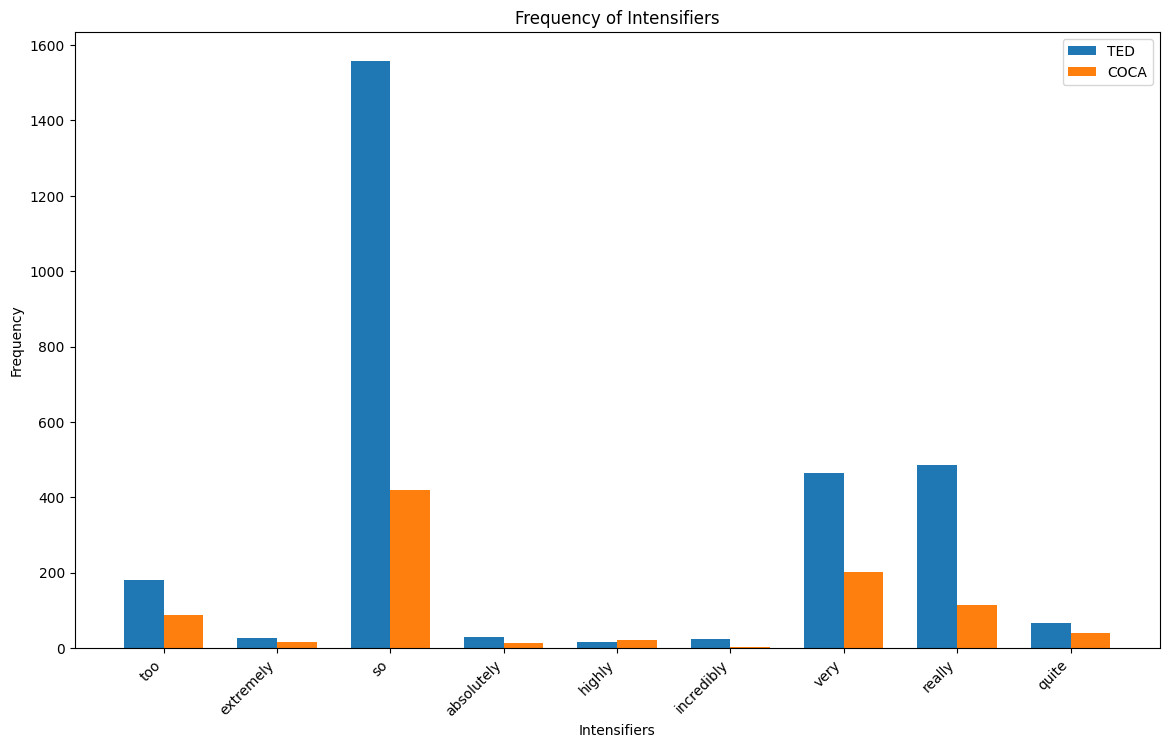

In [ ]:
import requests
import pandas as pd
import nltk
from io import StringIO
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chi2_contingency

# Download NLTK data files (only need to be done once)
nltk.download('punkt')

# List of common intensifiers
intensifiers = ['very', 'extremely', 'quite', 'really', 'so', 'too', 'absolutely', 'highly', 'incredibly']

def download_csv(url):
    """Download a CSV file from a given URL and return it as a pandas DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        csv_raw = StringIO(response.text)
        df = pd.read_csv(csv_raw)
        return df
    else:
        raise Exception(f"Failed to download CSV. Status code: {response.status_code}")

def extract_text(df):
    """Extract and combine text from all columns of a DataFrame."""
    text = ' '.join(df.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1))
    return text

def count_intensifiers(text, intensifiers):
    """Count the occurrences of each intensifier in the text."""
    tokens = nltk.word_tokenize(text.lower())
    counter = Counter(tokens)
    intensifier_counts = {word: counter[word] for word in intensifiers}
    return intensifier_counts

def plot_intensifier_frequencies(counts1, counts2, title1, title2):
    """Plot the frequencies of intensifiers in two datasets."""
    intensifiers = list(set(list(counts1.keys()) + list(counts2.keys())))
    frequencies1 = [counts1.get(word, 0) for word in intensifiers]
    frequencies2 = [counts2.get(word, 0) for word in intensifiers]

    x = range(len(intensifiers))  # Label locations

    fig, ax = plt.subplots(figsize=(14, 8))
    width = 0.35  # Width of the bars

    ax.bar(x, frequencies1, width, label=title1)
    ax.bar([p + width for p in x], frequencies2, width, label=title2)

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Intensifiers')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency of Intensifiers')
    ax.set_xticks([p + width/2 for p in x])
    ax.set_xticklabels(intensifiers, rotation=45, ha='right')
    ax.legend()

    plt.show()

# URLs of the CSV files (use the raw version of the file from GitHub)
ted_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/TEDcleandata.csv'
coca_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/finalcocatext.csv'

try:
    # Download the CSV files from GitHub
    df_ted = download_csv(ted_csv_url)
    df_coca = download_csv(coca_csv_url)

    # Extract text from the DataFrames
    text_ted = extract_text(df_ted)
    text_coca = extract_text(df_coca)

    # Count intensifiers in both texts
    intensifier_counts_ted = count_intensifiers(text_ted, intensifiers)
    intensifier_counts_coca = count_intensifiers(text_coca, intensifiers)

    # Create a contingency table
    intensifiers_list = list(intensifier_counts_ted.keys())
    contingency_table = [
        [intensifier_counts_ted[intensifier], intensifier_counts_coca[intensifier]] for intensifier in intensifiers_list
    ]

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Create DataFrames for better display
    contingency_table_df = pd.DataFrame(contingency_table, columns=['TED', 'COCA'], index=intensifiers_list)
    expected_df = pd.DataFrame(expected, columns=['TED', 'COCA'], index=intensifiers_list)

    # Display results
    print("\nContingency Table:")
    print(contingency_table_df)
    print("\nChi-Square Test Results")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected frequencies:")
    print(expected_df)

    # Save results to CSV files
    contingency_table_df.to_csv('intensifiers_contingency_table04.csv', index=True)
    expected_df.to_csv('intensifiers_expected_frequencies04.csv', index=True)
    results_df = pd.DataFrame({
        'Chi-square statistic': [chi2],
        'P-value': [p],
        'Degrees of freedom': [dof]
    })
    results_df.to_csv('intensifiers_chi_square_results04.csv', index=False)

    print("Results saved to CSV files successfully.")

    # Plot the intensifier frequencies
    plot_intensifier_frequencies(intensifier_counts_ted, intensifier_counts_coca, 'TED', 'COCA')

except Exception as e:
    print(e)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Contingency Table:
             TED  COCA
very         465   201
extremely     26    15
quite         66    39
really       487   113
so          1557   419
too          180    87
absolutely    28    14
highly        16    22
incredibly    25     3

Chi-Square Test Results
Chi-square statistic: 83.3710
P-value: 0.0000
Degrees of freedom: 8

Expected frequencies:
                    TED        COCA
very         504.411374  161.588626
extremely     31.052352    9.947648
quite         79.524316   25.475684
really       454.424661  145.575339
so          1496.571884  479.428116
too          202.218974   64.781026
absolutely    31.809726   10.190274
highly        28.780229    9.219771
incredibly    21.206484    6.793516
Results saved to CSV files successfully.


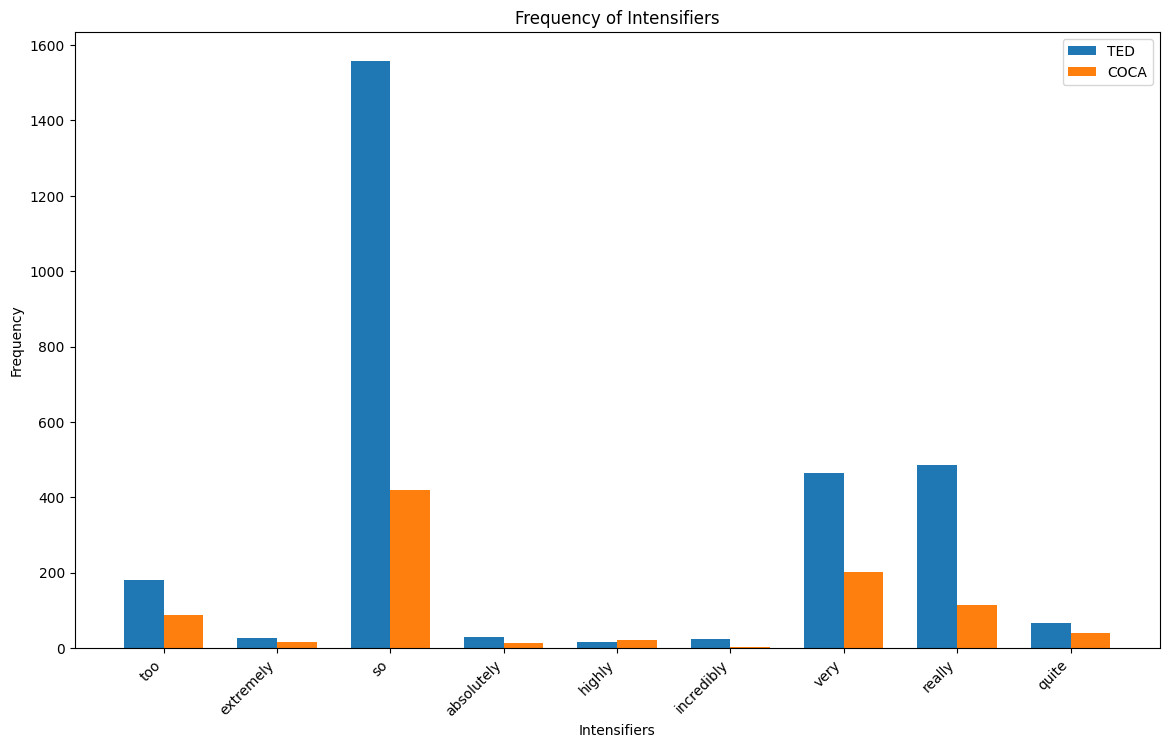

In [ ]:
import requests
import pandas as pd
import nltk
from io import StringIO
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chi2_contingency

# Download NLTK data files (only need to be done once)
nltk.download('punkt')

# List of common intensifiers
intensifiers = ['very', 'extremely', 'quite', 'really', 'so', 'too', 'absolutely', 'highly', 'incredibly']

def download_csv(url):
    """Download a CSV file from a given URL and return it as a pandas.DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        csv_raw = StringIO(response.text)
        df = pd.read_csv(csv_raw)
        return df
    else:
        raise Exception(f"Failed to download CSV. Status code: {response.status_code}")

def extract_text(df):
    """Extract and combine text from all columns of a DataFrame."""
    text = ' '.join(df.fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1))
    return text

def count_intensifiers(text, intensifiers):
    """Count the occurrences of each intensifier in the text."""
    tokens = nltk.word_tokenize(text.lower())
    counter = Counter(tokens)
    intensifier_counts = {word: counter[word] for word in intensifiers}
    return intensifier_counts

def plot_intensifier_frequencies(counts1, counts2, title1, title2):
    """Plot the frequencies of intensifiers in two datasets."""
    intensifiers = list(set(list(counts1.keys()) + list(counts2.keys())))
    frequencies1 = [counts1.get(word, 0) for word in intensifiers]
    frequencies2 = [counts2.get(word, 0) for word in intensifiers]

    x = range(len(intensifiers))  # Label locations

    fig, ax = plt.subplots(figsize=(14, 8))
    width = 0.35  # Width of the bars

    ax.bar(x, frequencies1, width, label=title1)
    ax.bar([p + width for p in x], frequencies2, width, label=title2)

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Intensifiers')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency of Intensifiers')
    ax.set_xticks([p + width/2 for p in x])
    ax.set_xticklabels(intensifiers, rotation=45, ha='right')
    ax.legend()

    plt.show()

# URLs of the CSV files (use the raw version of the file from GitHub)
ted_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/TEDcleandata.csv'
coca_csv_url = 'https://github.com/Englishson0909/S24Corpus-final/raw/main/finalcocatext.csv'

try:
    # Download the CSV files from GitHub
    df_ted = download_csv(ted_csv_url)
    df_coca = download_csv(coca_csv_url)

    # Extract text from the DataFrames
    text_ted = extract_text(df_ted)
    text_coca = extract_text(df_coca)

    # Count intensifiers in both texts
    intensifier_counts_ted = count_intensifiers(text_ted, intensifiers)
    intensifier_counts_coca = count_intensifiers(text_coca, intensifiers)

    # Create a contingency table
    intensifiers_list = list(intensifier_counts_ted.keys())
    contingency_table = [
        [intensifier_counts_ted[intensifier], intensifier_counts_coca[intensifier]] for intensifier in intensifiers_list
    ]

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Create DataFrames for better display
    contingency_table_df = pd.DataFrame(contingency_table, columns=['TED', 'COCA'], index=intensifiers_list)
    expected_df = pd.DataFrame(expected, columns=['TED', 'COCA'], index=intensifiers_list)

    # Display results
    print("\nContingency Table:")
    print(contingency_table_df)
    print("\nChi-Square Test Results")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected frequencies:")
    print(expected_df)

    # Save results to CSV files
    contingency_table_df.to_csv('intensifiers_contingency_table03.csv', index=True)
    expected_df.to_csv('intensifiers_expected_frequencies03.csv', index=True)
    results_df = pd.DataFrame({
        'Chi-square statistic': [chi2],
        'P-value': [p],
        'Degrees of freedom': [dof]
    })
    results_df.to_csv('intensifiers_chi_square_results03.csv', index=False)

    print("Results saved to CSV files successfully.")

    # Plot the intensifier frequencies
    plot_intensifier_frequencies(intensifier_counts_ted, intensifier_counts_coca, 'TED', 'COCA')

except Exception as e:
    print(e)
